In [2]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('order_items.csv','order_items'),
    ('payments.csv', 'payments')  # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='4599',
    database='ecommers'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'Documents/eCOMMERS'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()


Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [10]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(host ="localhost",
                            username = "root",
                            password="4599",
                            database ="ecommers")


cur =db.cursor()





# 1.List all unique cities where customers are located.

In [4]:
 


query =""" select distinct (customer_city) from customers"""

cur.execute(query)

data=cur.fetchall()

df= pd.DataFrame(data)
print(df)




                          0
0                    franca
1     sao bernardo do campo
2                 sao paulo
3           mogi das cruzes
4                  campinas
...                     ...
4114                 siriji
4115    natividade da serra
4116           monte bonito
4117             sao rafael
4118      eugenio de castro

[4119 rows x 1 columns]


# 2.Count the number of orders placed in 2017.

In [5]:


query =""" select count(order_id) from orders where year (order_purchase_timestamp) = 2017"""

cur.execute(query)

data=cur.fetchall()

"the total number of orders placed in 2017",data[0][0]



('the total number of orders placed in 2017', 315707)

# 3.Find the total sales per category.

In [6]:


query =""" select upper(products.product_category) category, 
round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category

"""

cur.execute(query)

data=cur.fetchall()

df = pd.DataFrame(data,columns = ["category","sales"])
df


,category,sales
0,PERFUMERY,1.064151e+08
1,FURNITURE DECORATION,3.003370e+08
2,TELEPHONY,1.022452e+08
3,BED TABLE BATH,3.596363e+08
4,AUTOMOTIVE,1.789818e+08
...,...,...
69,CDS MUSIC DVDS,2.518803e+05
70,LA CUISINE,6.118413e+05
71,FASHION CHILDREN'S CLOTHING,1.649907e+05
72,PC GAMER,4.566303e+05


# 4.Calculate the percentage of orders that were paid in installments

In [7]:


query =""" select (sum(case when payment_installments >=1 then 1
else 0 end))/count(*)*100 from payments"""

cur.execute(query)

data=cur.fetchall()

"the percentage of orders that were paid in installments is",data



('the percentage of orders that were paid in installments is',
 [(Decimal('99.9981'),)])

# 5.Count the number of customers from each state.

   state  customer_count
0     SP          292222
4     RJ           89964
2     MG           81445
5     RS           38262
3     PR           35315
1     SC           25459
9     BA           23660
13    DF           14980
8     ES           14231
7     GO           14140
15    PE           11564
12    CE            9352
6     PA            6825
16    MT            6349
10    MA            5229
11    MS            5005
21    PB            3752
23    PI            3465
14    RN            3395
19    AL            2891
25    SE            2450
22    TO            1960
20    RO            1771
17    AM            1036
24    AC             567
18    AP             476
26    RR             322


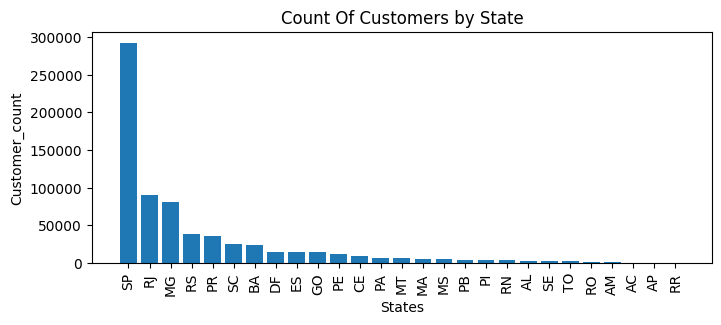

In [9]:

query =""" select customer_state ,count(customer_id)
from customers group by customer_state"""

cur.execute(query)

data=cur.fetchall()

df= pd.DataFrame(data,columns =["state","customer_count"])
df = df.sort_values(by= "customer_count",ascending = False)
print(df)

plt.figure(figsize= (8,3))
plt.bar(df["state"],df["customer_count"])
plt.xticks(rotation=90)
plt.xlabel("States")
plt.ylabel("Customer_count")
plt.title("Count Of Customers by State")
plt.show()                 

# 6.Calculate the number of orders per month in 2018.

      months  order_count
0       July        44044
1     August        45584
2   February        47096
3       June        43169
4      March        50477
5    January        50883
6        May        48111
7      April        48573
8  September          112
9    October           28


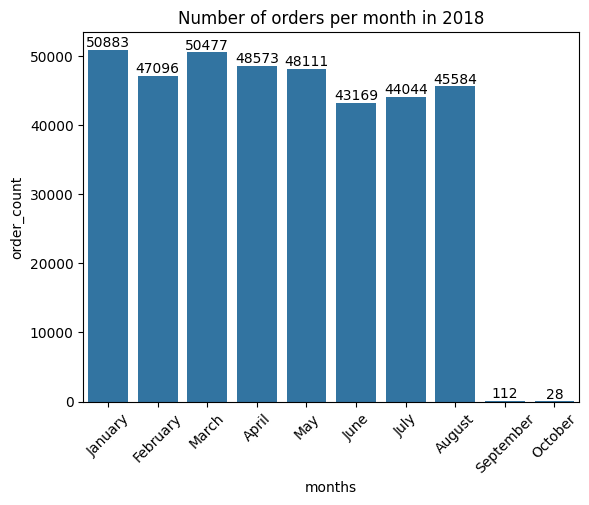

In [10]:

import seaborn as sns
query =""" select monthname (order_purchase_timestamp) months, count(order_id) order_count
from orders where year (order_purchase_timestamp) = 2018
group by months
"""

cur.execute(query)

data=cur.fetchall()

df= pd.DataFrame(data, columns = ["months", "order_count"])
print(df)
o = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October"]
ax = sns.barplot(x = df["months"], y = df["order_count"], data = df,order= o)
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.title("Number of orders per month in 2018")
plt.show()

# 7.Find the average number of products per order, grouped by customer city.

In [11]:


query ="""with count_per_order as 
(select orders.order_id,orders.customer_id,count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id ,orders.customer_id)

select customers.customer_city,round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc

"""

cur.execute(query)

data=cur.fetchall()

df= pd.DataFrame(data,columns =["customer city ","average products/order"])
df.head(10)


,customer city,average products/order
0,padre carvalho,294.00
1,celso ramos,273.00
2,datas,252.00
3,candido godoi,252.00
4,matias olimpio,210.00
5,cidelandia,168.00
6,curralinho,168.00
7,picarra,168.00
8,morro de sao paulo,168.00
9,teixeira soares,168.00


# 8.Calculate the percentage of total revenue contributed by each product category.

In [12]:


query =""" select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value)from payments))*100,2) sales_percentage
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc



"""

cur.execute(query)

data=cur.fetchall()

df = pd.DataFrame(data,columns = ["category","percentage distribution"])
df.head(10)


,category,percentage distribution
0,BED TABLE BATH,449.30
1,HEALTH BEAUTY,434.82
2,COMPUTER ACCESSORIES,415.92
3,FURNITURE DECORATION,375.21
4,WATCHES PRESENT,374.96
5,SPORT LEISURE,365.23
6,HOUSEWARES,287.21
7,AUTOMOTIVE,223.60
8,GARDEN TOOLS,219.93
9,COOL STUFF,204.56


# 9.Identify the correlation between product price and the number of times a product has been purchased

In [13]:

import numpy as np
query ="""SELECT products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id =  order_items.product_id
group by products.product_category """

cur.execute(query)

data=cur.fetchall()

df = pd.DataFrame(data,columns = ["Category", "order_count","price"])
df
arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("the correlation between product price and the number of times a product has been purchased",a[0][-1])

the correlation between product price and the number of times a product has been purchased -0.10631514167157573


# 10. Calculate the total revenue generated by each seller, and rank them by revenue.

                             seller_id       revenue  rank
0     7c67e1448b00f6e969d365cea6b010ab  1.521501e+07     1
1     1025f0e2d44d7041d6cf58b6550e0bfa  9.246661e+06     2
2     4a3ca9315b744ce9f8e9374361493884  9.037358e+06     3
3     1f50f920176fa81dab994f9023523100  8.707603e+06     4
4     53243585a1d6dc2643021fd1853d8905  8.547092e+06     5
...                                ...           ...   ...
3090  ad14615bdd492b01b0d97922e87cb87f  5.763000e+02  3082
3091  702835e4b785b67a084280efca355756  5.568000e+02  3083
3092  4965a7002cca77301c82d3f91b82e1a9  4.908000e+02  3084
3093  77128dec4bec4878c37ab7d6169d6f26  4.566000e+02  3085
3094  cf6f6bc4df3999b9c6440f124fb2f687  3.666000e+02  3086

[3095 rows x 3 columns]


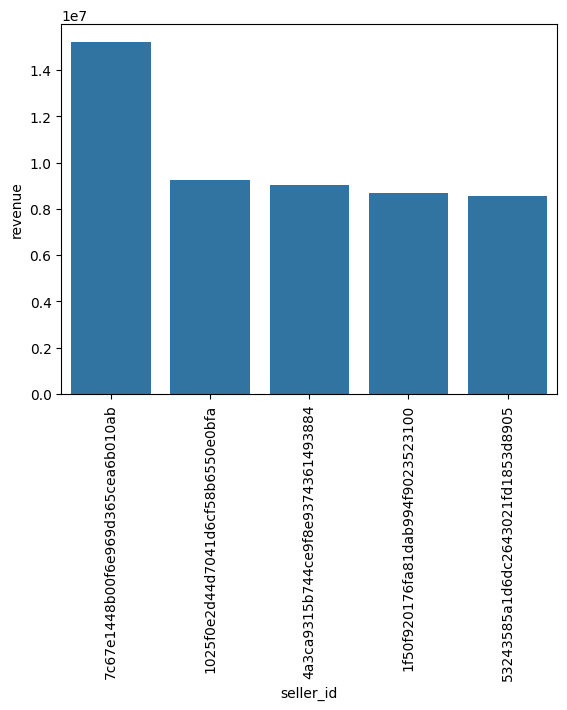

In [14]:

import pandas as pd
import seaborn as sns
query ="""select *, dense_rank() over(order by revenue desc) as rn from 
(SELECT order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments 
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
print(df)
df = df.head()
sns.barplot(x = "seller_id", y = "revenue", data= df)
plt.xticks(rotation = 90)
plt.show()



# 11.Calculate the moving average of order values for each customer over their order history.

In [15]:



query ="""select customer_id ,order_purchase_timestamp,payment,
avg(payment) over(PARTITION BY customer_id ORDER BY order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg from
(select orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a  
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["customer_id","order_purchase_timestamp","payment","moving average"])
print(df)


                              customer_id order_purchase_timestamp  payment  \
0        00012a2ce6f8dcda20d059ce98491703      2017-11-14 16:08:26   114.74   
1        00012a2ce6f8dcda20d059ce98491703      2017-11-14 16:08:26   114.74   
2        00012a2ce6f8dcda20d059ce98491703      2017-11-14 16:08:26   114.74   
3        00012a2ce6f8dcda20d059ce98491703      2017-11-14 16:08:26   114.74   
4        00012a2ce6f8dcda20d059ce98491703      2017-11-14 16:08:26   114.74   
...                                   ...                      ...      ...   
3636005  ffffe8b65bbe3087b653a978c870db99      2017-09-29 14:07:03    18.37   
3636006  ffffe8b65bbe3087b653a978c870db99      2017-09-29 14:07:03    18.37   
3636007  ffffe8b65bbe3087b653a978c870db99      2017-09-29 14:07:03    18.37   
3636008  ffffe8b65bbe3087b653a978c870db99      2017-09-29 14:07:03    18.37   
3636009  ffffe8b65bbe3087b653a978c870db99      2017-09-29 14:07:03    18.37   

         moving average  
0            114.739998  

# 12.Calculate the cumulative sales per month for each year

In [16]:



query = """ select years, months , payment, sum(payment)
over(order by years, months) cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a
"""


cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns = ["years", "months","payment","cumulative sales per month"])
df

,years,months,payment,cumulative sales per month
0,2016,9,8828.40,8.828400e+03
1,2016,10,2068166.80,2.076995e+06
2,2016,12,686.70,2.077682e+06
3,2017,1,4847081.40,6.924763e+06
4,2017,2,10216780.33,1.714154e+07
5,2017,3,15745225.98,3.288677e+07
6,2017,4,14622581.03,4.750935e+07
7,2017,5,20752158.70,6.826151e+07
8,2017,6,17894673.31,8.615618e+07
9,2017,7,20733402.18,1.068896e+08


# 13. Calculate the year-over-year growth rate of total sales.

In [28]:


query = """ with a as (select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment-lag(payment,1) over(order by years))/ 
lag(payment,1) over(order by years))*100 from a
"""


cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns =["years", "yoy  % growth"])
print(df)

   years  yoy  % growth
0   2016            NaN
1   2017   12112.703758
2   2018      20.000924


# 14 .Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [18]:


query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
print(df)

      0
0  None


# 15 Identify the top 3 customers who spent the most money in each year.

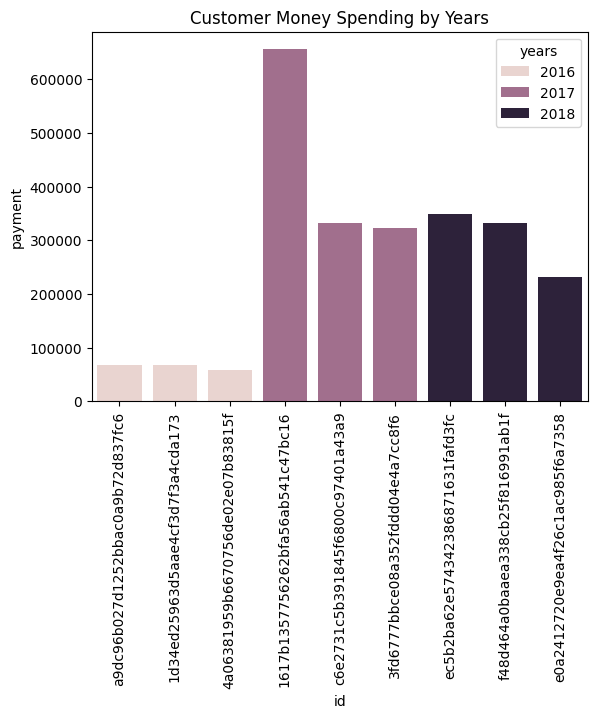

In [22]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.title("Customer Money Spending by Years")
plt.xticks(rotation = 90)
plt.show()